In [6]:
'''

HOARDING PROJECT USL BOLOGNA 

Purpose: HDDMrl analysis of the PRL data as a function of diagnostic category and stimulus.

(1) diag_cat (diagnostic category) 

- DDA    hoarding disorder, 
- HC     comunity sample, 

(2) stim (stimulus)

- trigger objects,
- neutral.

Written by Ilaria Colpizzi 

'''


import datetime
now = datetime.datetime.now()
print("Current date and time : ")
print(now.strftime("%Y-%m-%d %H:%M:%S"))


Current date and time : 
2023-03-09 14:26:07


This notebook follows the [tutorial](https://hddm.readthedocs.io/en/latest/demo_RLHDDMtutorial.html#checking-results) on the hddm webpage.


In [7]:
# Import modules

# warning settings
import hddm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc.progressbar as pbar
import pymc
import pathlib
import kabuki
from kabuki.utils import concat_models
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin
from patsy import dmatrix  # for generation of (regression) design matrices
import pickle
import numpy as np
from pandas import Series  # to manipulate data-frames generated by hddm
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Data management
pd.options.display.max_colwidth = 100

# Plotting
%matplotlib inline

sns.set()  # for plot styling
plt.style.use('classic')

# HDDM
print("The hddm version is", hddm.__version__)

# print(pickle.format_version)


The hddm version is 0.9.7


In [8]:
# custom save/load fns
def savePatch(self, fname):
    with open(fname, 'wb') as f:  # write binary
        pickle.dump(self, f)


hddm.HDDM.savePatch = savePatch


def load1(fname):
    model = pickle.load(open(fname, 'rb'))
    return model


hddm.load1 = load1


In [9]:
# custom fns (workaround) to compute posterior predictive checks for HDDM Regressor models
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node):  # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()
                   ) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]


def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            # Only modification of original Kabuki code
            sampled_data.reset_index(inplace=True)
            sampled_data = sampled_data.join(
                data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)
    return datasets


def post_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    results = {}
    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = ((name, model.data.ix[obs['node'].value.index])
                     for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue  # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(
            node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(
            datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=['node'])


In [10]:
pwd

'/Users/ilaria/Documents/phd_projects/hoarding_project/hoarding_project/scripts'

In [6]:
# load accuracy-coded data ('response' column represents accuracy: 1=correct trial; 0=error trial) CHANGE!!!
#data = hddm.load_csv(
    #'/Users/ilaria/Documents/phd_projects/hoarding_project/hoarding_project/data/processed/_prl/input_for_hddmrl/hddm_input_20230105.csv')


In [11]:
data=hddm.load_csv(
    '../data/processed/_prl/input_for_hddmrl/hddm_input_20230105.csv'
)

In [12]:
print('There are %d participants' % data['subj_idx'].nunique())

There are 67 participants


In [13]:
data["subj_idx"].unique()
# tony_el haber_1998_05_18_507_m da eliminare 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

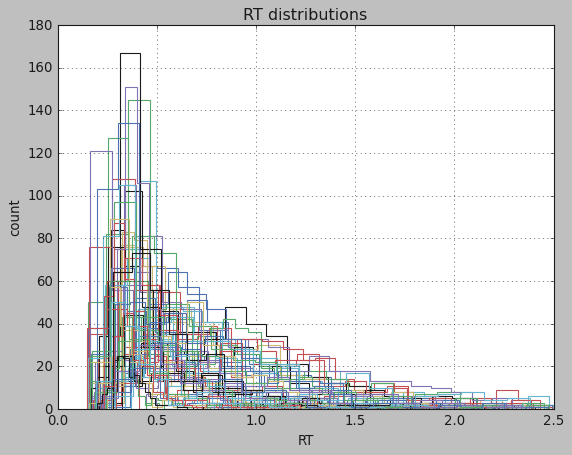

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count',
                     title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
plt.savefig('plot_hist_rt_patients.pdf')


In [15]:
data.groupby(['diag_cat', 'stim']).agg({'feedback': 'mean'})

feedback
diag_cat stim              
DDA      hoarding  0.499519
         neutral   0.537500
HC       hoarding  0.535320
         neutral   0.538081

In [126]:
data.groupby(['diag_cat', 'stim']).agg({'response': 'mean'})

response
diag_cat stim              
DDA      hoarding  0.443750
         neutral   0.478846
HC       hoarding  0.507267
         neutral   0.498983

In [238]:
df = data[(data.diag_cat == 'HC') & (data.stim == "neutral")]
a = df.groupby(['subj_idx']).agg({'rt': 'mean'})
print(*a['rt'])
a

0.8956000000000002 0.686625 1.0897750000000004 0.5646062500000002 0.7930625000000002 0.6275687499999996 0.4782187500000002 0.5226437500000001 0.5458000000000002 1.1375437500000005 0.7982375000000002 0.4727 0.4221749999999999 0.4162437499999997 0.4980125 0.39241250000000016 0.41369375 0.46421874999999985 0.3961937500000001 0.7445312500000001 0.45810625000000016 0.4464781249999999 0.8243625 0.38770000000000004 0.37685 0.3917499999999999 0.6175374999999996 0.4331062500000001 0.3722125 0.3723187499999999 0.4679312500000001 0.42924375000000003 0.6531187499999997 0.39690000000000025 0.7504812500000002 0.8445187499999995 0.34685625000000003 0.36156249999999995 0.7974375000000001 0.4325312500000001 0.4211187499999999 0.4370875000000001


,rt
subj_idx,
10,0.895600
11,0.686625
12,1.089775
13,0.564606
14,0.793063
15,0.627569
16,0.478219
17,0.522644
19,0.545800


In [150]:
df2 = a[a.rt > 0.7]
# df2['subj_idx']
df2

,rt
subj_idx,
10,0.896631
12,1.092794
14,0.800463
20,1.130463
21,0.792694
33,0.754500
39,0.824662
56,0.747794
57,0.840812


In [151]:
good_idx = [10, 12, 14, 20, 21, 33, 39, 56, 57, 60]

In [161]:
data1 = data.loc[data['subj_idx'].isin(good_idx)]
np.shape(data1)

(2720, 10)

In [16]:
df = data[data.diag_cat == 'DDA']
df.describe()

,subj_idx,response,rt,trial,split_by,feedback,q_init
count,4160.000000,4160.000000,4160.000000,4160.000000,4160.00000,4160.000000,4160.0
mean,7.000000,0.461298,0.848811,80.500000,0.50000,0.518510,0.5
std,3.742107,0.498560,0.453241,46.192672,0.50006,0.499717,0.0
min,1.000000,0.000000,0.185000,1.000000,0.00000,0.000000,0.5
25%,4.000000,0.000000,0.495000,40.750000,0.00000,0.000000,0.5
50%,7.000000,0.000000,0.734500,80.500000,0.50000,1.000000,0.5
75%,10.000000,1.000000,1.081000,120.250000,1.00000,1.000000,0.5
max,13.000000,1.000000,2.497000,160.000000,1.00000,1.000000,0.5


In [19]:
df1 = data[data.diag_cat == 'HC']
df1.describe()


,subj_idx,response,rt,trial,split_by,feedback,q_init
count,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.000000,13760.0
mean,37.616279,0.503125,0.595773,80.500000,0.500000,0.536701,0.5
std,14.936194,0.500008,0.358206,46.188798,0.500018,0.498669,0.0
min,14.000000,0.000000,0.150000,1.000000,0.000000,0.000000,0.5
25%,25.000000,0.000000,0.351000,40.750000,0.000000,0.000000,0.5
50%,37.000000,1.000000,0.470000,80.500000,0.500000,1.000000,0.5
75%,50.000000,1.000000,0.730000,120.250000,1.000000,1.000000,0.5
max,67.000000,1.000000,2.499000,160.000000,1.000000,1.000000,0.5


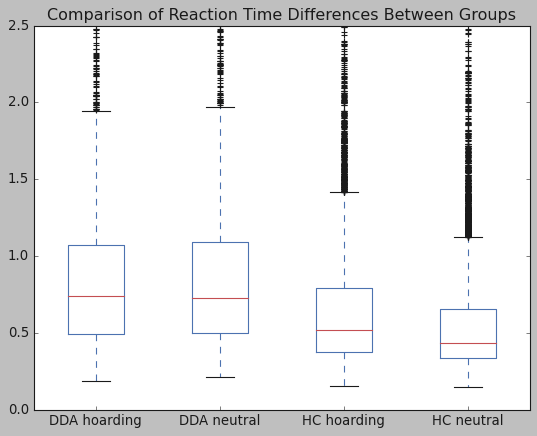

In [17]:
anf = data[(data.diag_cat == "DDA") & (data.stim == "hoarding")]
ann = data[(data.diag_cat == "DDA") & (data.stim == "neutral")]
hcf = data[(data.diag_cat == "HC") & (data.stim == "hoarding")]
hcn = data[(data.diag_cat == "HC") & (data.stim == "neutral")]

plt.boxplot([anf.rt.values, ann.rt.values, hcf.rt.values, hcn.rt.values],
            labels=('DDA hoarding', 'DDA neutral', 'HC hoarding', 'HC neutral'),)
plt.title('Comparison of Reaction Time Differences Between Groups')
plt.show()


In [18]:
data.head()

,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init
0,1,1,hoarding,2.041,1,0,1,DDA,gi_ca_1956_07_06_016_f,0.5
1,1,1,neutral,1.337,1,1,1,DDA,gi_ca_1956_07_06_016_f,0.5
2,1,1,hoarding,1.457,2,0,0,DDA,gi_ca_1956_07_06_016_f,0.5
3,1,1,neutral,0.746,2,1,0,DDA,gi_ca_1956_07_06_016_f,0.5
4,1,0,hoarding,1.772,3,0,1,DDA,gi_ca_1956_07_06_016_f,0.5


In [21]:
data.shape

(17920, 10)

In [22]:
#####
# RUN MODEL mod1
#####

# a = decision threshold
# v = drift rate
# t = non-decision time
# alpha = learning rate from negative feedbacks
# pos_alpha = learning rate from positive feedbacks

mod1 = hddm.HDDMrl(
    data,
    # bias=True,
    depends_on={
        'a': ['diag_cat', 'stim'],
        'v': ['diag_cat', 'stim'],
        't': ['diag_cat', 'stim'],
        'alpha': ['diag_cat', 'stim'],
        'pos_alpha': ['diag_cat', 'stim']
    },
    dual=True,  # separate learning rates for pos/neg feedbacks
    p_outlier=0.05,
    informative=True  # informative priors on ddm params
)


No model attribute --> setting up standard HDDM
Set model to ddm


In [23]:
mod1.find_starting_values()


/Users/ilaria/opt/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [24]:
mod1.sample(5000, burn=1000, dbname='models/ddm.db', db='pickle')

 [-----------------100%-----------------] 5001 of 5000 complete in 1465.5 sec

In [25]:
# get model traces 
grptrcs=mod1.get_group_traces() # traces of all stochastic group nodes
alltrcs=mod1.get_traces() # traces of all stochastic nodes

In [26]:
# export traces to .csv files (for later use in R)
grptrcs.to_csv('ddm/ddm_grptrcs.csv')
alltrcs.to_csv('ddm/ddm_alltrcs.csv')

In [27]:
print("mod1 DIC: %f" % mod1.dic)

mod1 DIC: 14066.230609


Done saving traces (202206180603)

In [28]:
# get the individual node
subj_data = mod1.get_subj_nodes()
# subj_Data.head()


In [29]:
alpha_dda_h,  alpha_dda_n, alpha_hc_h,  alpha_hc_n = mod1.nodes_db.node[[
    'alpha(DDA.hoarding)',   'alpha(DDA.neutral)',
    'alpha(HC.hoarding)',   'alpha(HC.neutral)'
]]


In [30]:
traces = mod1.get_traces()
traces.head()


,a(DDA.hoarding),a(DDA.neutral),a(HC.hoarding),a(HC.neutral),a_std,a_subj(DDA.hoarding).1,a_subj(DDA.hoarding).2,a_subj(DDA.hoarding).3,a_subj(DDA.hoarding).4,a_subj(DDA.hoarding).5,...,pos_alpha_subj(HC.neutral).58,pos_alpha_subj(HC.neutral).59,pos_alpha_subj(HC.neutral).60,pos_alpha_subj(HC.neutral).61,pos_alpha_subj(HC.neutral).62,pos_alpha_subj(HC.neutral).63,pos_alpha_subj(HC.neutral).64,pos_alpha_subj(HC.neutral).65,pos_alpha_subj(HC.neutral).66,pos_alpha_subj(HC.neutral).67
0,1.466983,1.509067,1.374529,1.250988,0.275096,2.110125,0.973036,1.811824,1.538696,1.222530,...,1.896273,-0.826704,7.714084,-0.926467,0.623740,1.009066,-1.062648,2.201948,2.024118,8.651264
1,1.448136,1.426942,1.345590,1.215027,0.284510,1.814783,0.994580,1.709665,1.402849,1.247596,...,-0.000333,1.574813,7.560201,-1.301599,0.020783,0.909057,-2.122987,1.976817,1.785362,4.472604
2,1.502959,1.410275,1.364928,1.295247,0.274519,2.037789,0.995037,1.746106,1.435721,1.231032,...,5.384557,0.927736,4.455451,-0.302477,1.442120,0.902828,-4.388967,2.096451,0.272215,0.989776
3,1.399150,1.462652,1.412526,1.175663,0.286683,2.000070,0.957156,1.645187,1.552565,1.273909,...,5.212061,1.142730,5.170227,2.699979,0.897322,0.405005,-1.581852,6.438693,1.309516,4.570682
4,1.688058,1.552519,1.406519,1.201900,0.290992,1.934027,0.980258,1.753403,1.462849,1.357800,...,6.925628,0.553439,3.903669,4.599955,2.302148,-0.097052,-1.224277,1.593037,0.808834,0.852785


In [31]:
traces.to_csv("traces.csv")


In [ ]:
# alpha_an_f.trace()


In [34]:
traces['score_diff'] = traces['pos_alpha(DDA.neutral)'] - \
    traces['pos_alpha(HC.neutral)']


The following code creates a figure of the posterior density plot of the difference between the parameters estimated in two conditions.


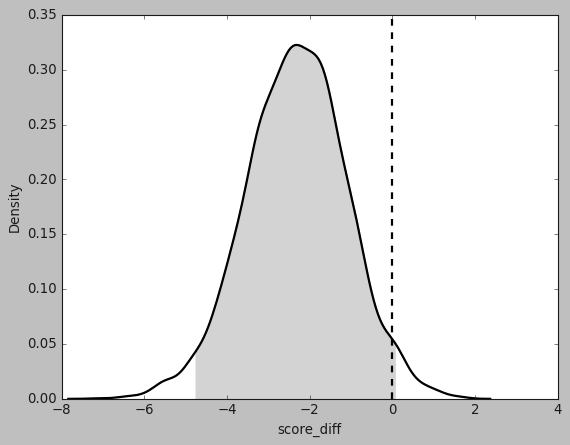

In [35]:
quantiles = traces['score_diff'].quantile([0.025, 0.975])

# Define delta lower and upper limits
low, high = quantiles[0.025], quantiles[0.975]

sns_plot = sns.kdeplot(data=traces, x="score_diff")

line = sns_plot.lines[0]
x, y = line.get_data()

plt.plot(x, y, color='black', lw=2)

idx_delta = np.logical_and(x >= low, x <= high)

plt.fill_between(x, y, where=idx_delta, color='lightgray')

plt.axvline(0, color='black', linestyle='--', linewidth=2)

sns_plot.figure.savefig("output.pdf")


In [36]:
# get model traces
grptrcs = mod1.get_group_traces()  # traces of all stochastic group nodes
alltrcs = mod1.get_traces()  # traces of all stochastic nodes


In [29]:
# export traces to .csv files (for later use in R)
grptrcs.to_csv('ddm/ddm_grptrcs.csv')
alltrcs.to_csv('ddm/ddm_alltrcs.csv')


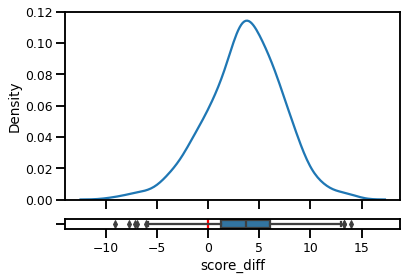

In [114]:
# # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
# f, (ax_kdeplot, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.95, .05)})

# # assigning a graph to each ax

# sns.kdeplot(data=traces, x="score_diff", ax=ax_kdeplot)
# plt.axvline(0, color='r')

# sns.boxplot(data=traces, x="score_diff", ax=ax_box)

# # Remove x axis name for the boxplot
# # ax_box.set(xlabel='')
# plt.show()

# # plt.savefig('plot_score_diff.pdf')


In [37]:
alpha_dda_h,  alpha_dda_n, alpha_hc_h,  alpha_hc_n = mod1.nodes_db.node[[
    'alpha(DDA.hoarding)',   'alpha(DDA.neutral)',
    'alpha(HC.hoarding)',   'alpha(HC.neutral)'
]]


In [38]:
pos_alpha_dda_h,  pos_alpha_dda_n, pos_alpha_hc_h, pos_alpha_hc_n = mod1.nodes_db.node[[
    'pos_alpha(DDA.hoarding)',   'pos_alpha(DDA.neutral)',
    'pos_alpha(HC.hoarding)', 'pos_alpha(HC.neutral)'
]]


In [39]:
a_dda_h,  a_dda_n, a_hc_h, a_hc_n = mod1.nodes_db.node[[
    'a(DDA.hoarding)', 'a(DDA.neutral)',
    'a(HC.hoarding)', 'a(HC.neutral)'
]]


In [40]:
v_dda_h,  v_dda_n, v_hc_h, v_hc_n = mod1.nodes_db.node[[
    'v(DDA.hoarding)', 'v(DDA.neutral)',
    'v(HC.hoarding)', 'v(HC.neutral)'
]]

In [41]:
t_dda_h,  t_dda_n, t_hc_h, t_hc_n = mod1.nodes_db.node[[
    't(DDA.hoarding)', 't(DDA.neutral)',
    't(HC.hoarding)', 't(HC.neutral)'
]]

In [42]:
mod1.plot_posterior_predictive()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Positive Alpha: Group Differences 


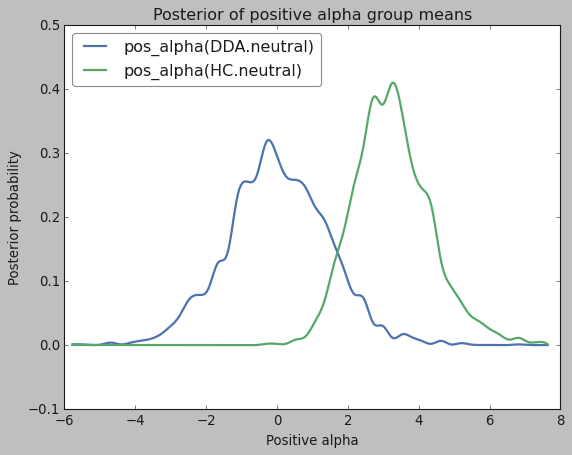

In [92]:
hddm.analyze.plot_posterior_nodes([pos_alpha_dda_n, pos_alpha_hc_n])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')
plt.savefig('pos_alpha_group_means_neutral.pdf', pad_inches=4.5)


In [93]:
print("P(pos-alpha DDA neutral > pos-alpha HC neutral) = ",
      (pos_alpha_dda_n.trace() > pos_alpha_hc_n.trace()).mean())

P(pos-alpha DDA neutral > pos-alpha HC neutral) =  0.0285


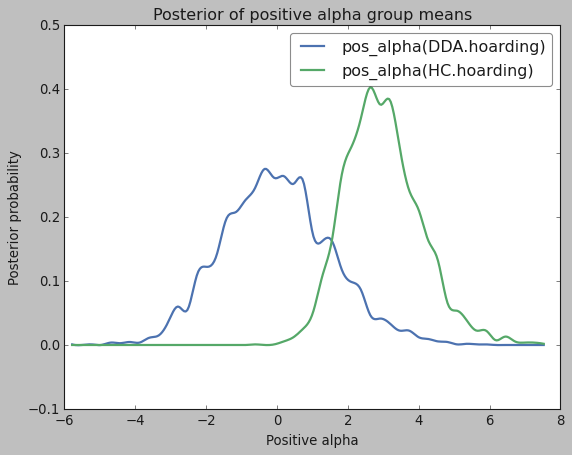

In [94]:
hddm.analyze.plot_posterior_nodes([pos_alpha_dda_h, pos_alpha_hc_h])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of positive alpha group means')
plt.savefig('pos_alpha_group_means_hoarding.pdf', pad_inches=4.5)

In [74]:
print("P(pos-alpha DDA hoarding > pos-alpha HC hoarding) = ",
      (pos_alpha_dda_h.trace() > pos_alpha_hc_h.trace()).mean())

P(pos-alpha DDA hoarding > pos-alpha HC hoarding) =  0.05325


## Negative Alpha: Group Differences

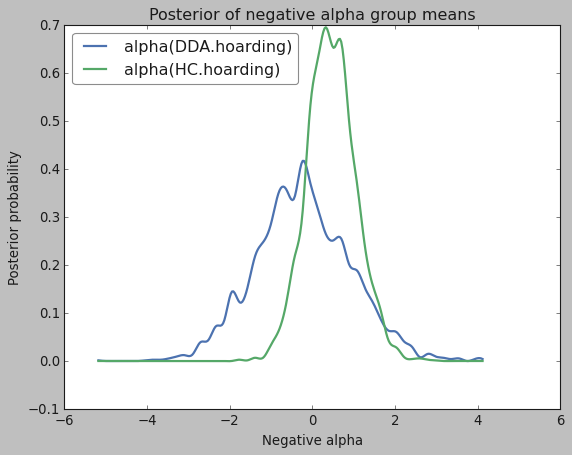

In [95]:
hddm.analyze.plot_posterior_nodes([alpha_dda_h, alpha_hc_h])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')
plt.savefig('alpha_group_means_hoarding.pdf', pad_inches=4.5)

In [76]:
print("P(alpha DDA hoarding > alpha HC hoarding) = ",
      (alpha_dda_h.trace() > alpha_hc_h.trace()).mean())

P(alpha DDA hoarding > alpha HC hoarding) =  0.29775


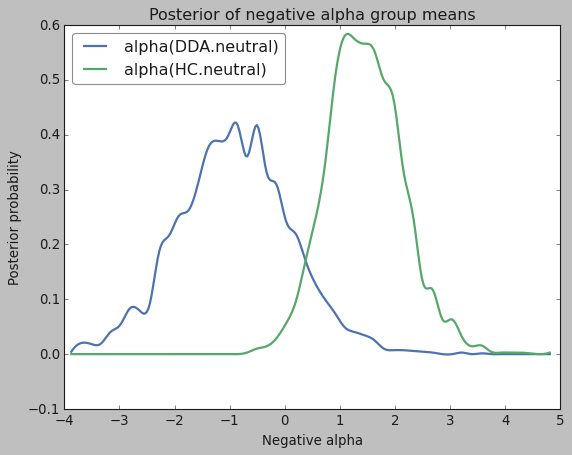

In [96]:
hddm.analyze.plot_posterior_nodes([alpha_dda_n, alpha_hc_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of negative alpha group means')
plt.savefig('alpha_group_means_neutral.pdf', pad_inches=4.5)

In [78]:
print("P(alpha DDA neutral > alpha HC neutral) = ",
      (alpha_dda_n.trace() > alpha_hc_n.trace()).mean())

P(alpha DDA neutral > alpha HC neutral) =  0.0295


In [63]:
np.exp(3)/(1+np.exp(3))

0.9525741268224333

## a parameter: Group Differences 

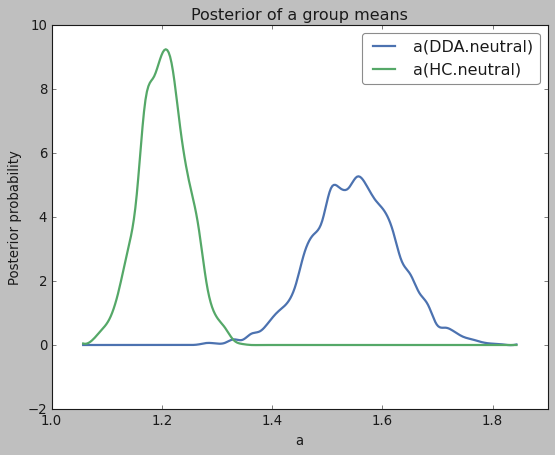

In [97]:
hddm.analyze.plot_posterior_nodes([a_dda_n, a_hc_n])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of a group means')
plt.savefig('a_group_diff_neutral.pdf', pad_inches=4.5)

In [80]:
print("P(a DDA neutral > a HC neutral) = ",
      (a_dda_n.trace() > a_hc_n.trace()).mean())

P(a DDA neutral > a HC neutral) =  0.99975


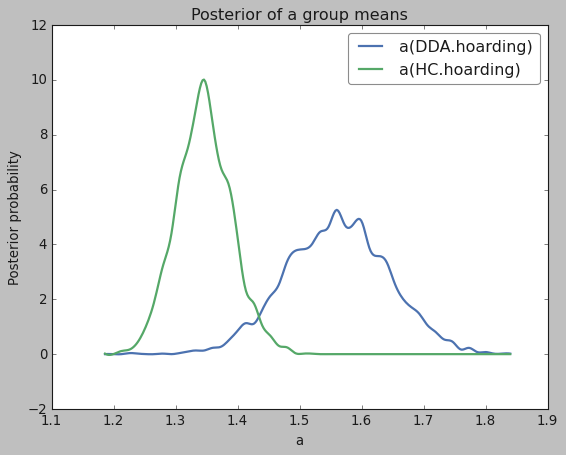

In [98]:
hddm.analyze.plot_posterior_nodes([a_dda_h, a_hc_h])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of a group means')
plt.savefig('a_group_diff_hoarding.pdf', pad_inches=4.5)

In [82]:
print("P(a DDA hoarding > a HC hoarding) = ",
      (a_dda_h.trace() > a_hc_h.trace()).mean())

P(a DDA hoarding > a HC hoarding) =  0.98675


## v parameter: Group Differences

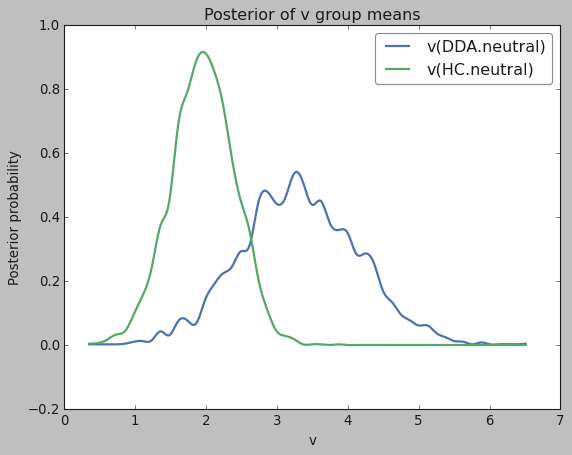

In [99]:
hddm.analyze.plot_posterior_nodes([v_dda_n, v_hc_n])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of v group means')
plt.savefig('v_group_diff_nautral.pdf', pad_inches=4.5)

In [84]:
print("P(v DDA neutral > v HC neutral) = ",
      (v_dda_n.trace() > v_hc_n.trace()).mean())

P(v DDA neutral > v HC neutral) =  0.929


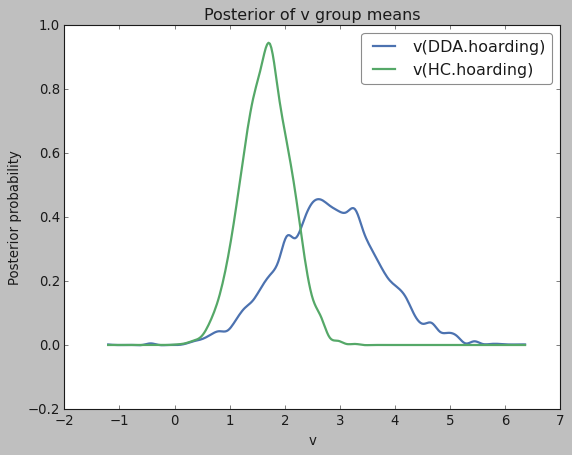

In [100]:
hddm.analyze.plot_posterior_nodes([v_dda_h, v_hc_h])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of v group means')
plt.savefig('v_group_diff_hoarding.pdf', pad_inches=4.5)

In [86]:
print("P(v DDA hoarding > v HC hoarding) = ",
      (v_dda_h.trace() > v_hc_h.trace()).mean())

P(v DDA hoarding > v HC hoarding) =  0.87


# t parameter: Group Differences


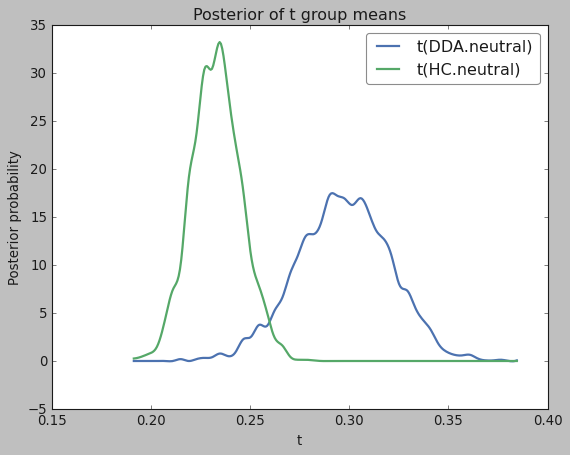

In [101]:
hddm.analyze.plot_posterior_nodes([t_dda_n, t_hc_n])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of t group means')
plt.savefig('t_group_diff_neutral.pdf', pad_inches=4.5)

In [88]:
print("P(t DDA neutral > t HC neutral) = ",
      (t_dda_n.trace() > t_hc_n.trace()).mean())

P(t DDA neutral > t HC neutral) =  0.9905


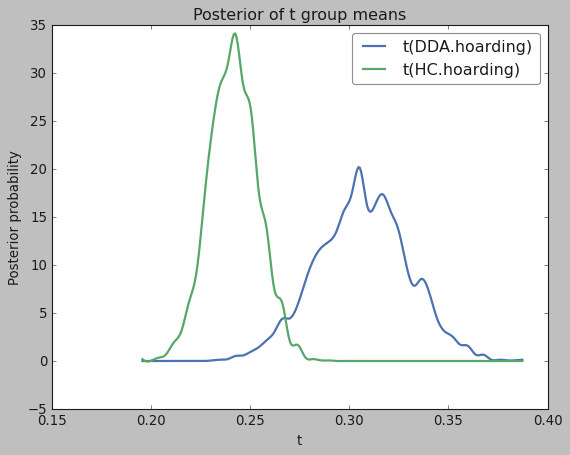

In [102]:
hddm.analyze.plot_posterior_nodes([t_dda_h, t_hc_h])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of t group means')
plt.savefig('t_group_diff_hoarding.pdf', pad_inches=4.5)

In [90]:
print("P(t DDA hoarding > t HC hoarding) = ",
      (t_dda_h.trace() > t_hc_h.trace()).mean())

P(t DDA hoarding > t HC hoarding) =  0.99275


## Positive Alpha: Domain-Specificity Effect

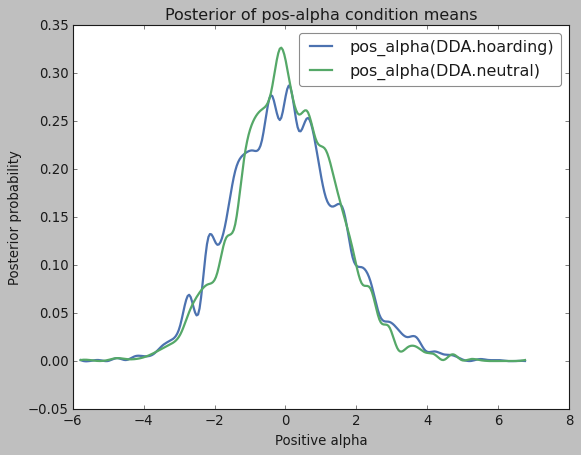

In [103]:
hddm.analyze.plot_posterior_nodes([pos_alpha_dda_h, pos_alpha_dda_n])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of pos-alpha condition means')
plt.savefig('pos_alpha_patients.pdf', pad_inches=4.5)

In [104]:
print("P(pos alpha DDA hoarding > pos alpha DDA neutral) = ",
      (pos_alpha_dda_h.trace() > pos_alpha_dda_n.trace()).mean())

P(pos alpha DDA hoarding > pos alpha DDA neutral) =  0.48125


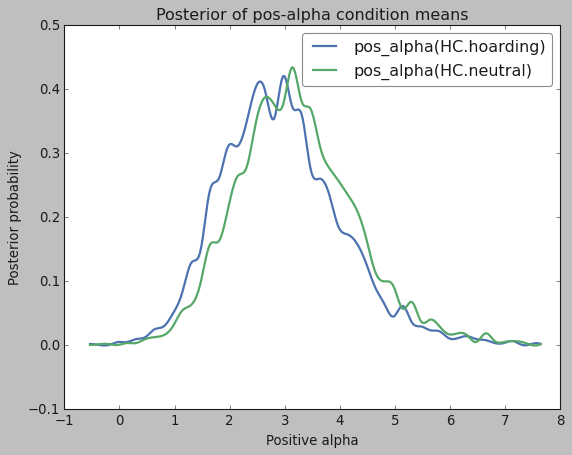

In [106]:
hddm.analyze.plot_posterior_nodes([pos_alpha_hc_h, pos_alpha_hc_n])
plt.xlabel('Positive alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of pos-alpha condition means')
plt.savefig('pos_alpha_controls.pdf', pad_inches=4.5)

In [107]:
print("P(pos alpha HC hoarding > pos alpha HC neutral) = ",
      (pos_alpha_hc_h.trace() > pos_alpha_hc_n.trace()).mean())

P(pos alpha HC hoarding > pos alpha HC neutral) =  0.41875


# Negative Alpha: Domain-Specificity Effect


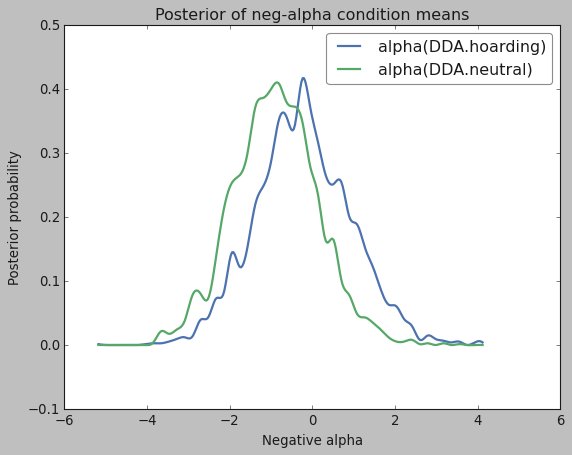

In [108]:
hddm.analyze.plot_posterior_nodes([alpha_dda_h, alpha_dda_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of neg-alpha condition means')
plt.savefig('neg_alpha_patients.pdf', pad_inches=4.5)

In [109]:
print("P(neg alpha DDA hoarding > neg alpha DDA neutral) = ",
      (alpha_dda_h.trace() > alpha_dda_n.trace()).mean())

P(neg alpha DDA hoarding > neg alpha DDA neutral) =  0.666


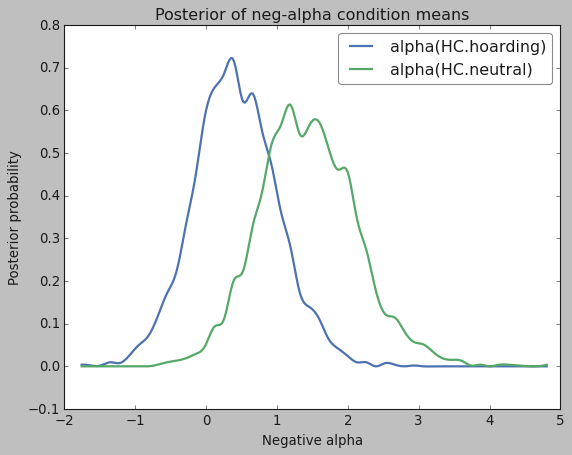

In [110]:
hddm.analyze.plot_posterior_nodes([alpha_hc_h, alpha_hc_n])
plt.xlabel('Negative alpha')
plt.ylabel('Posterior probability')
plt.title('Posterior of neg-alpha condition means')
plt.savefig('neg_alpha_controls.pdf', pad_inches=4.5)

In [111]:
print("P(neg alpha HC hoarding > neg alpha HC neutral) = ",
      (alpha_hc_h.trace() > alpha_hc_n.trace()).mean())

P(neg alpha HC hoarding > neg alpha HC neutral) =  0.12775


## a parameter: Domain-specificity Effect

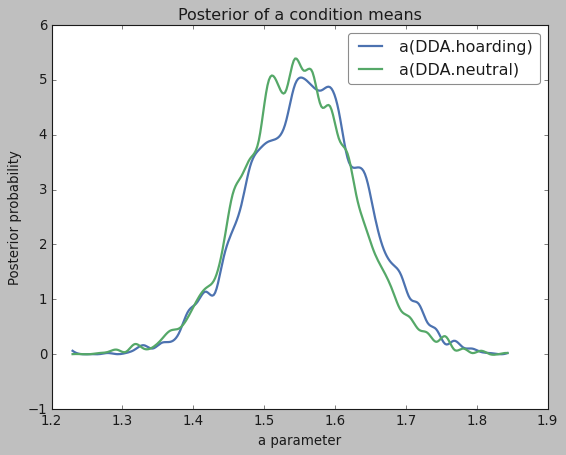

In [112]:
hddm.analyze.plot_posterior_nodes([a_dda_h, a_dda_n])
plt.xlabel('a parameter')
plt.ylabel('Posterior probability')
plt.title('Posterior of a condition means')
plt.savefig('a_patients.pdf', pad_inches=4.5)

In [113]:
print("P(a DDA hoarding > a DDA neutral) = ",
      (a_dda_h.trace() > a_dda_n.trace()).mean())

P(a DDA hoarding > a DDA neutral) =  0.543


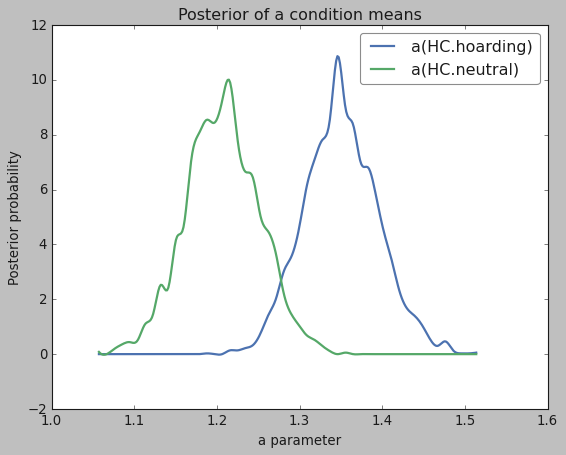

In [114]:
hddm.analyze.plot_posterior_nodes([a_hc_h, a_hc_n])
plt.xlabel('a parameter')
plt.ylabel('Posterior probability')
plt.title('Posterior of a condition means')
plt.savefig('a_controls.pdf', pad_inches=4.5)

In [115]:
print("P(a HC hoarding > a HC neutral) = ",
      (a_hc_h.trace() > a_hc_n.trace()).mean())

P(a HC hoarding > a HC neutral) =  0.99025


# t parameter: Domain-specificity Effect


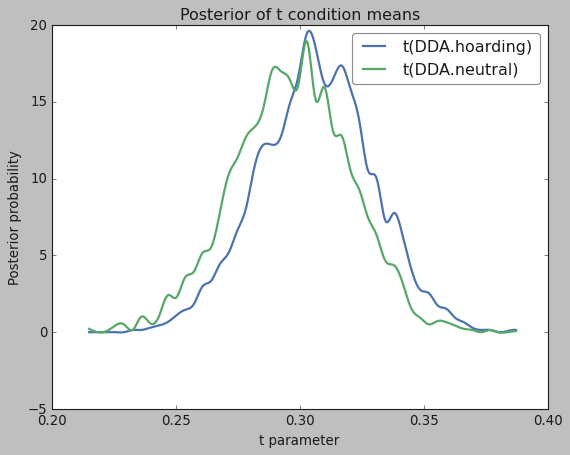

In [116]:
hddm.analyze.plot_posterior_nodes([t_dda_h, t_dda_n])
plt.xlabel('t parameter')
plt.ylabel('Posterior probability')
plt.title('Posterior of t condition means')
plt.savefig('t_patients.pdf', pad_inches=4.5)

In [117]:
print("P(t DDA hoarding > t DDA neutral) = ",
      (t_dda_h.trace() > t_dda_n.trace()).mean())

P(t DDA hoarding > t DDA neutral) =  0.60525


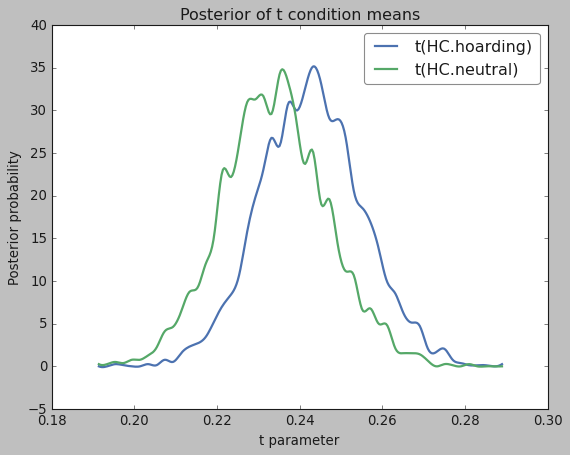

In [118]:
hddm.analyze.plot_posterior_nodes([t_hc_h, t_hc_n])
plt.xlabel('t parameter')
plt.ylabel('Posterior probability')
plt.title('Posterior of t condition means')
plt.savefig('t_controls.pdf', pad_inches=4.5)

In [119]:
print("P(t HC hoarding > t HC neutral) = ",
      (t_hc_h.trace() > t_hc_n.trace()).mean())

P(t HC hoarding > t HC neutral) =  0.70025


## v parameter: Domain-specificity Effect

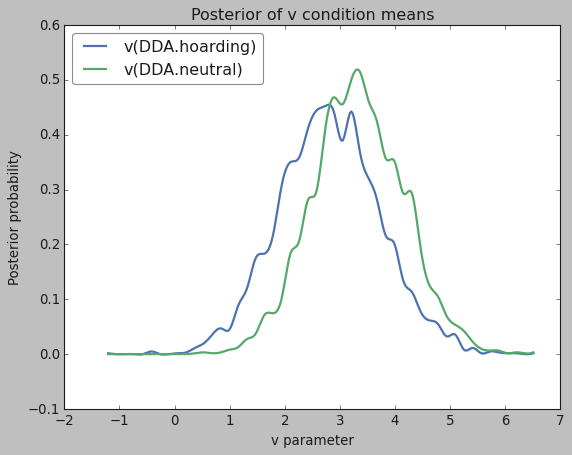

In [120]:
hddm.analyze.plot_posterior_nodes([v_dda_h, v_dda_n])
plt.xlabel('v parameter')
plt.ylabel('Posterior probability')
plt.title('Posterior of v condition means')
plt.savefig('v_patients.pdf', pad_inches=4.5)

In [121]:
print("P(v DDA hoarding > v DDA neutral) = ",
      (v_dda_h.trace() > v_dda_n.trace()).mean())

P(v DDA hoarding > v DDA neutral) =  0.343


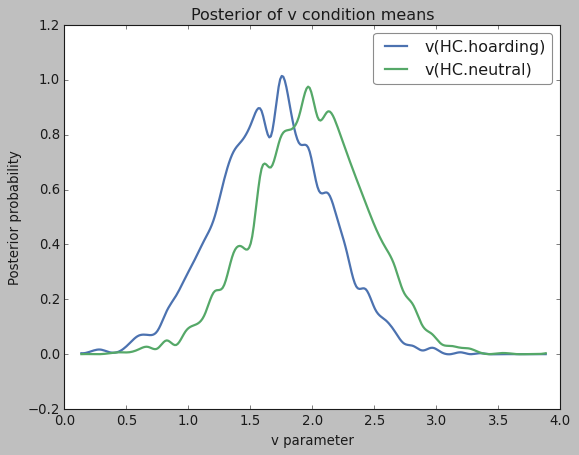

In [122]:
hddm.analyze.plot_posterior_nodes([v_hc_h, v_hc_n])
plt.xlabel('v parameter')
plt.ylabel('Posterior probability')
plt.title('Posterior of v condition means')
plt.savefig('v_controls.pdf', pad_inches=4.5)

In [123]:
print("P(v HC hoarding > v HC neutral) = ",
      (v_hc_h.trace() > v_hc_n.trace()).mean())

P(v HC hoarding > v HC neutral) =  0.30525


# Print fitted parameters and other model statistics


In [124]:
mod1.print_stats()


                                      mean         std        2.5q        25q         50q        75q      97.5q       mc err
a(DDA.hoarding)                    1.55969   0.0806202     1.40144    1.50367     1.56042    1.61393    1.71693   0.00149493
a(DDA.neutral)                     1.54691   0.0772768     1.39471    1.49545     1.54662    1.59808    1.70175   0.00119396
a(HC.hoarding)                     1.34903   0.0439931     1.26529    1.31954     1.34752    1.37785    1.44022  0.000966419
a(HC.neutral)                       1.2081   0.0436007     1.12221    1.17921      1.2079    1.23762    1.29454  0.000820936
a_std                               0.2819   0.0218432    0.242644   0.266973    0.280866   0.295678   0.327709  0.000571194
a_subj(DDA.hoarding).1             1.90313    0.109013     1.67348    1.83583     1.90391    1.97236    2.11527   0.00474948
a_subj(DDA.hoarding).2               1.076   0.0739197    0.948013    1.02388     1.07161    1.12329    1.23121   0.00239132


## Checking results


In [ ]:
mod1.plot_posteriors()

### Estimate convergence


In [21]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        data,
        # bias=True,
        depends_on={
            'a': ['diag_cat', 'stim'],
            'v': ['diag_cat', 'stim'],
            't': ['diag_cat', 'stim'],
            'alpha': ['diag_cat', 'stim'],
            'pos_alpha': ['diag_cat', 'stim']
        },
        dual=True,  # separate learning rates for pos/neg feedbacks
        p_outlier=0.05,
        informative=True
    )
    m.sample(1500, burn=500, dbname='traces.db', db='pickle')
    models.append(m)


No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1501 of 1500 complete in 3326.8 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1501 of 1500 complete in 3345.7 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1501 of 1500 complete in 3304.8 sec

In [22]:
gel_rub = gelman_rubin(models)
str(gel_rub)

"{'a(AN.food)': 0.999660794786233, 'a(AN.neutral)': 0.9995872842343416, 'a(AN_R.food)': 1.0017754461803174, 'a(AN_R.neutral)': 1.0008705536011613, 'a(BN.food)': 1.0019401200092943, 'a(BN.neutral)': 1.0004257242329653, 'a(BN_R.food)': 1.0009399092142501, 'a(BN_R.neutral)': 1.002049243928591, 'a(HC.food)': 1.000412858127868, 'a(HC.neutral)': 0.9998525665312364, 'a(RI.food)': 0.9999823494962898, 'a(RI.neutral)': 1.0005676958921998, 'a_std': 1.0005542201135467, 'a_subj(AN.food).1': 0.9995631520306192, 'a_subj(AN.food).6': 1.0040901439925844, 'a_subj(AN.food).7': 0.999672702040121, 'a_subj(AN.food).9': 0.9995023127892654, 'a_subj(AN.food).10': 0.9999541047735875, 'a_subj(AN.food).11': 1.0033796615067543, 'a_subj(AN.food).12': 1.0006720650623901, 'a_subj(AN.food).13': 1.000394176392688, 'a_subj(AN.food).18': 1.0011686584026507, 'a_subj(AN.food).19': 0.9999450630356429, 'a_subj(AN.food).20': 1.0007504601221322, 'a_subj(AN.food).23': 1.005496875936693, 'a_subj(AN.food).24': 1.0015359015399272,

In [23]:
np.max(list(gelman_rubin(models).values()))


1.0757867285905993

In [24]:
np.mean(list(gelman_rubin(models).values()))


1.0020651472099595

In [25]:
# Combine the models we ran to test for convergence.
m = kabuki.utils.concat_models(models)


Another test of the model is to look at collinearity. If the estimation of parameters is very codependent (correlation is strong) it can indicate that their variance trades off, in particular if there is a negative correlation. The following plot shows there is generally low correlation across all combinations of parameters. It does not seem to be the case for this dataset, but common for RLDDM is a negative correlation between learning rate and the scaling factor, similar to what’s usually observed between learning rate and inverse temperature for RL models that uses softmax as the choice rule (e.g. Daw, 2011).


In [26]:
alpha_an_f, alpha_an_n, alpha_hc_f, alpha_hc_n, pos_alpha_an_f, pos_alpha_an_n, pos_alpha_hc_f, pos_alpha_hc_n, t_an_f, t_an_n, t_hc_f, t_hc_n, a_an_f, a_an_n, a_hc_f, a_hc_n, v_an_f, v_an_n, v_hc_f, v_hc_n = m.nodes_db.node[[
    'alpha(AN.food)', 'alpha(AN.neutral)', 'alpha(HC.food)', 'alpha(HC.neutral)',
    'pos_alpha(AN.food)', 'pos_alpha(AN.neutral)', 'pos_alpha(HC.food)', 'pos_alpha(HC.neutral)',
    't(AN.food)', 't(AN.neutral)', 't(HC.food)', 't(HC.neutral)',
    'a(AN.food)', 'a(AN.neutral)', 'a(HC.food)', 'a(HC.neutral)',
    'v(AN.food)', 'v(AN.neutral)', 'v(HC.food)', 'v(HC.neutral)'
]]


In [27]:
samples = {
    'alpha(AN.food)': alpha_an_f.trace(),
    'alpha(AN.neutral)': alpha_an_n.trace(),
    'alpha(HC.food)': alpha_hc_f.trace(),
    'alpha(HC.neutral)': alpha_hc_n.trace(),
    'pos_alpha(AN.food)': pos_alpha_an_f.trace(),
    'pos_alpha(AN.neutral)': pos_alpha_an_n.trace(),
    'pos_alpha(HC.food)': pos_alpha_hc_f.trace(),
    'pos_alpha(HC.neutral)': pos_alpha_hc_n.trace(),
    't(AN.food)': t_an_f.trace(),
    't(AN.neutral)': t_an_n.trace(),
    't(HC.food)': t_hc_f.trace(),
    't(HC.neutral)': t_hc_n.trace(),
    'a(AN.food)': a_an_f.trace(),
    'a(AN.neutral)': a_an_n.trace(),
    'a(HC.food)': a_hc_f.trace(),
    'a(HC.neutral)': a_hc_n.trace(),
    'v(AN.food)': v_an_f.trace(),
    'v(AN.neutral)': v_an_n.trace(),
    'v(HC.food)': v_hc_f.trace(),
    'v(HC.neutral)': v_hc_n.trace()
}


In [28]:
samples = {
    'alpha(AN.food)': alpha_an_f.trace(),
    'alpha(AN.neutral)': alpha_an_n.trace(),
    'pos_alpha(AN.food)': pos_alpha_an_f.trace(),
    'pos_alpha(AN.neutral)': pos_alpha_an_n.trace(),
    't(AN.food)': t_an_f.trace(),
    't(AN.neutral)': t_an_n.trace(),
    'a(AN.food)': a_an_f.trace(),
    'a(AN.neutral)': a_an_n.trace(),
    'v(AN.food)': v_an_f.trace(),
    'v(AN.neutral)': v_an_n.trace()
}


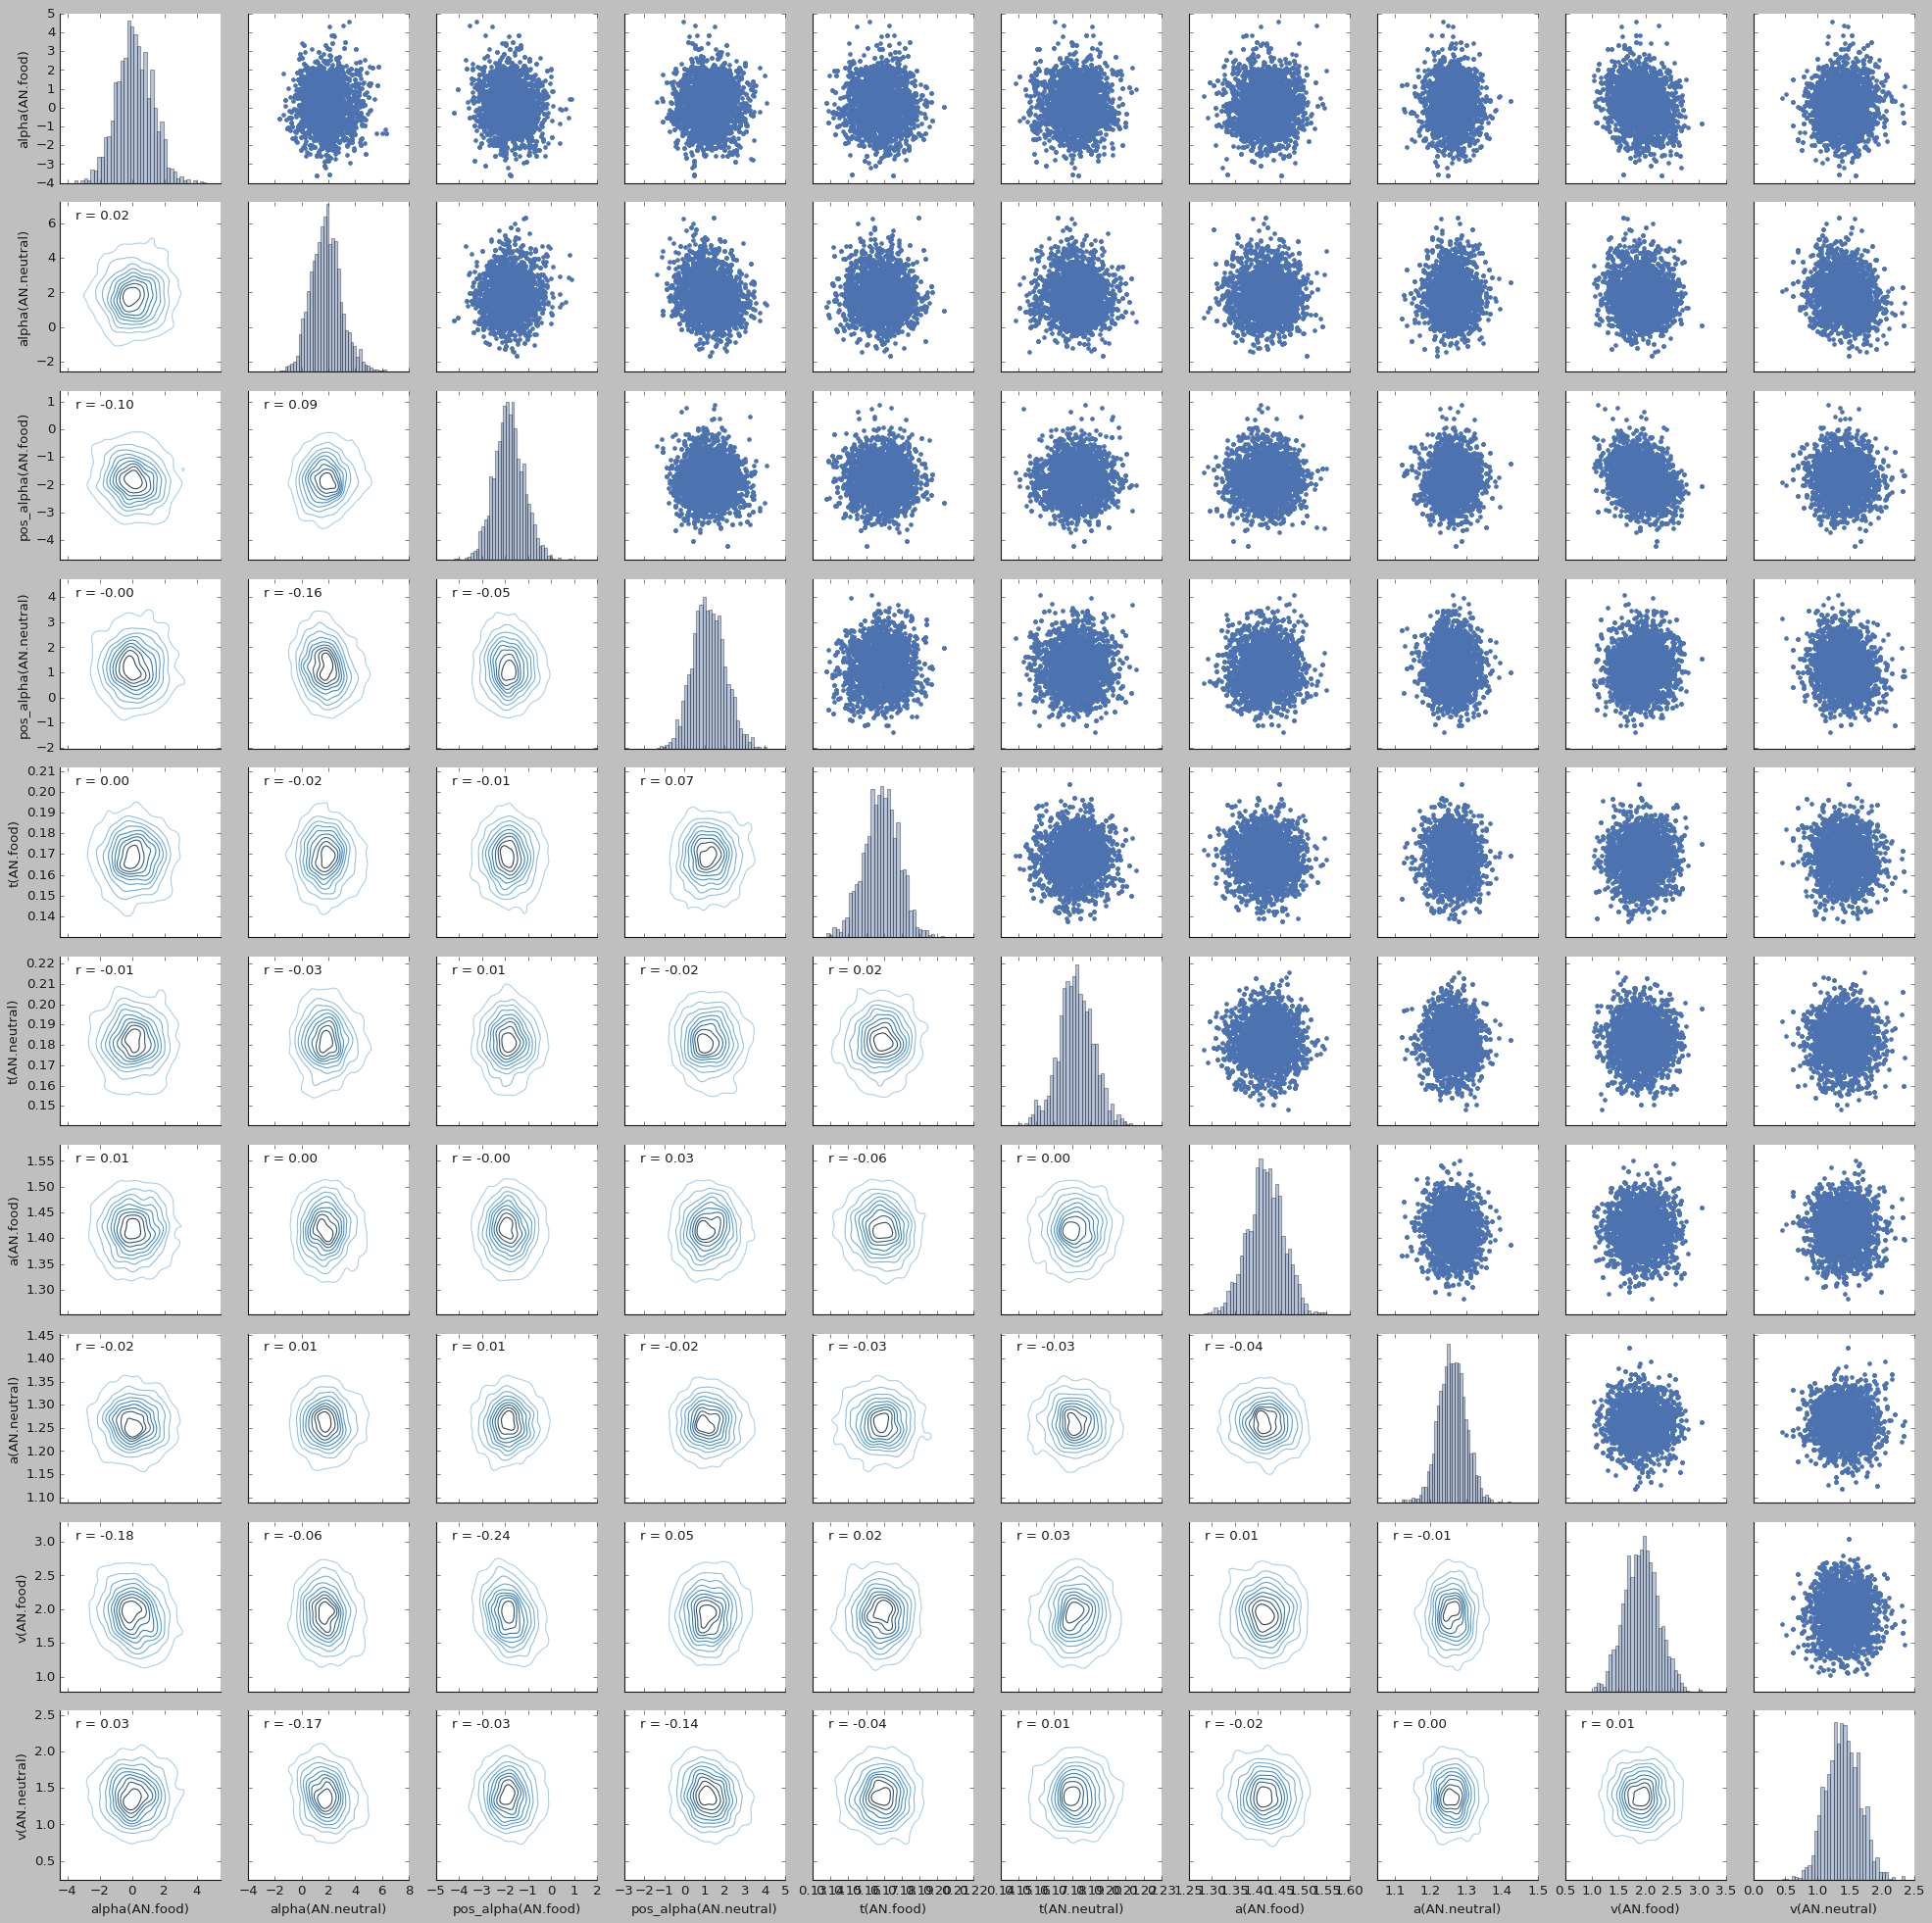

In [29]:
samp = pd.DataFrame(data=samples)


def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
g.savefig('matrix_plot.png')


## Posterior predictive checks


An important test of the model is its ability to recreate the observed data. This can be tested with posterior predictive checks, which involves simulating data using estimated parameters and comparing observed and simulated results.

The first step then is to extract the traces from the estimated model. The function get_traces() gives you the samples (row) from the approaximated posterior distribution for all of the estimated group and subject parameters (column).


#### AN food


In [219]:
data = data[
    (data.subj_code == "am_gu_1999_02_11_937_f") |  # AN
    (data.subj_code == "an_de_1998_11_10_289_f") |  # AN
    (data.subj_code == "gi_lo_2001_06_20_106_f") |  # HC
    (data.subj_code == "bi_ra_2000_09_28_341_f")   # HC
]

d = data[(data.diag_cat == "AN")]
d.shape


(640, 10)

In [234]:
d = data

In [220]:
# Change subj_idx
d.loc[d.subj_code == "am_gu_1999_02_11_937_f", "subj_idx"] = 0
d.loc[d.subj_code == "an_de_1998_11_10_289_f", "subj_idx"] = 1

d.tail()


,subj_idx,response,stim,rt,trial,split_by,feedback,diag_cat,subj_code,q_init
11195,1,1,neutral,0.527,158,1,1,AN,an_de_1998_11_10_289_f,0.5
11196,1,0,food,0.488,159,0,0,AN,an_de_1998_11_10_289_f,0.5
11197,1,1,neutral,0.323,159,1,1,AN,an_de_1998_11_10_289_f,0.5
11198,1,1,food,0.499,160,0,1,AN,an_de_1998_11_10_289_f,0.5
11199,1,1,neutral,0.402,160,1,1,AN,an_de_1998_11_10_289_f,0.5


In [236]:
models = []
for i in range(3):
    m = hddm.HDDMrl(
        d,
        # bias=True,
        p_outlier=0.05
    )
    m.sample(600, burn=100, dbname='traces.db', db='pickle')
    models.append(m)


No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 727.4 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 766.5 secNo model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 601 of 600 complete in 780.3 sec

In [52]:
# Combine the models
# m = kabuki.utils.concat_models(models)
traces = m.get_traces()
traces.head()


,a(AN.food),a(AN.neutral),a(AN_R.food),a(AN_R.neutral),a(BN.food),a(BN.neutral),a(BN_R.food),a(BN_R.neutral),a(HC.food),a(HC.neutral),...,pos_alpha_subj(RI.neutral).175,pos_alpha_subj(RI.neutral).178,pos_alpha_subj(RI.neutral).192,pos_alpha_subj(RI.neutral).208,pos_alpha_subj(RI.neutral).210,pos_alpha_subj(RI.neutral).223,pos_alpha_subj(RI.neutral).228,pos_alpha_subj(RI.neutral).244,pos_alpha_subj(RI.neutral).279,pos_alpha_subj(RI.neutral).286
0,1.419147,1.302546,1.175882,1.363120,1.384228,1.084609,1.323063,1.427180,1.344488,1.280353,...,0.295609,0.139912,0.108769,0.104712,0.084675,0.129573,0.176320,0.245254,0.161436,0.178513
1,1.345688,1.211257,1.267658,1.351603,1.432092,1.083462,1.346401,1.444872,1.315966,1.268457,...,0.155061,0.134077,0.074951,0.307244,0.070489,0.153472,0.206688,0.154490,0.306958,0.224305
2,1.427129,1.322904,1.407411,1.408192,1.523244,1.243772,1.409840,1.140137,1.350847,1.252018,...,0.338768,0.265431,0.093580,0.066371,0.106976,0.295046,0.208696,0.124594,0.095323,0.224523
3,1.356022,1.350327,1.267006,1.231057,1.391070,1.215077,1.318142,1.422669,1.340157,1.244962,...,0.035280,0.181331,0.102702,0.304889,0.108507,0.216067,0.265623,0.218978,0.103937,0.078373
4,1.338982,1.316591,1.435211,1.250458,1.326826,1.243233,1.391460,1.181983,1.331754,1.260010,...,0.263810,0.173877,0.242322,0.299826,0.137289,0.217771,0.126325,0.057155,0.128853,0.109847


Now that we have the traces the next step is to simulate data using the estimated parameters.

Inputs to function:

- a = decision threshold
- t = non-decision time
- alpha = learning rate pos*alpha = defaults to 0 -- if given it defines the learning rate for positive prediction errors. alpha then becomes the learning rate* for negative prediction errors.
- scaler = the scaling factor that is multiplied with the difference in q-values to calculate trial-by-trial drift rate p_upper = the probability of reward for the option represented by the upper boundary. The current version thus only works for outcomes that are either 1 or 0
- p_lower = the probability of reward for the option represented by the lower boundary.
- subjs = number of subjects to simulate data for.
- split_by = define the condition which makes it easier to append data from different conditions.
- size = number of trials per subject.


In [238]:
df = hddm.generate.gen_rand_rlddm_data(
    a=1.4,
    t=0.3,
    alpha=0.5,
    scaler=2,
    p_upper=0.7,
    p_lower=0.3,
    subjs=2,
    split_by=0,
    size=10
)


In [239]:
print(df)


       q_up     q_low  sim_drift  response        rt  feedback  subj_idx  \
0  0.500000  0.500000   0.000000       0.0  0.942301       0.0         0   
1  0.500000  0.253681   0.385249       1.0  0.482301       1.0         0   
2  0.746319  0.253681   0.770498       1.0  0.715301       1.0         0   
3  0.871292  0.253681   0.965959       1.0  0.421301       1.0         0   
4  0.934698  0.253681   1.065128       1.0  1.078301       1.0         0   
5  0.966868  0.253681   1.115443       1.0  0.441301       0.0         0   
6  0.490552  0.253681   0.370473       1.0  0.509301       1.0         0   
7  0.741526  0.253681   0.763001       1.0  1.793301       0.0         0   
8  0.376222  0.253681   0.191657       1.0  0.497301       1.0         0   
9  0.683519  0.253681   0.672277       0.0  0.796301       0.0         0   
0  0.500000  0.500000   0.000000       1.0  0.538185       1.0         1   
1  0.709846  0.500000   0.318455       0.0  0.884185       0.0         1   
2  0.709846 

In [240]:
from tqdm import tqdm  # progress tracker
# create empty dataframe to store simulated data
sim_data = pd.DataFrame()
# create a column samp to be used to identify the simulated data sets
d['samp'] = 0
# load traces
traces = m.get_traces()


In [242]:
# decide how many times to repeat simulation process. repeating this multiple times is generally recommended,
# as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1, 10)):
    # randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0, traces.shape[0]-1)
    # loop through all subjects in observed data
    for s in d.subj_idx.unique():
        # get number of trials for each condition.
        size0 = len(d[(d['subj_idx'] == s) & (
            d['split_by'] == 0)].trial.unique())
        size1 = len(d[(d['subj_idx'] == s) & (
            d['split_by'] == 1)].trial.unique())
        # size2 = len(d[(d['subj_idx']==s) & (d['split_by']==2)].trial.unique())
        # set parameter values for simulation
        a = traces.loc[sample, 'a_subj.'+str(s)]
        t = traces.loc[sample, 't_subj.'+str(s)]
        scaler = traces.loc[sample, 'v_subj.'+str(s)]
        alphaInv = traces.loc[sample, 'alpha_subj.'+str(s)]
        # #take inverse logit of estimated alpha
        alpha = np.exp(alphaInv)/(1+np.exp(alphaInv))
        # #simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rlddm_data(
            a=a, t=t, scaler=scaler, alpha=alpha, size=size0, p_upper=0.7, p_lower=0.3, split_by=0)
        sim_data1 = hddm.generate.gen_rand_rlddm_data(
            a=a, t=t, scaler=scaler, alpha=alpha, size=size1, p_upper=0.7, p_lower=0.3, split_by=1)
        # #sim_data2 = hddm.generate.gen_rand_rlddm_data(a=a,t=t,scaler=scaler,alpha=alpha,size=size2,p_upper=0.6,p_lower=0.4,split_by=2)
        # #append the conditions
        sim_data0 = sim_data0.append([sim_data1], ignore_index=True)
        # #assign subj_idx
        sim_data0['subj_idx'] = s
        # #identify that these are simulated data
        sim_data0['type'] = 'simulated'
        # #identify the simulated data
        sim_data0['samp'] = i
        # #append data from each subject
        sim_data = sim_data.append(sim_data0, ignore_index=True)


  0%|          | 0/9 [00:21<?, ?it/s]


KeyError: 0

In [227]:
# combine observed and simulated data
ppc_data = d[['subj_idx', 'response', 'split_by',
              'rt', 'trial', 'feedback', 'samp']].copy()
ppc_data['type'] = 'observed'
ppc_sdata = sim_data[['subj_idx', 'response', 'split_by',
                      'rt', 'trial', 'feedback', 'type', 'samp']].copy()
ppc_data = ppc_data.append(ppc_sdata)
ppc_data.to_csv('ppc_data_tutorial.csv')


In [228]:
# for practical reasons we only look at the first 40 trials for each subject in a given condition
plot_ppc_data = ppc_data[ppc_data.trial < 41].copy()

In [229]:
# bin trials to for smoother estimate of response proportion across learning
plot_ppc_data['bin_trial'] = pd.cut(
    plot_ppc_data.trial, 11, labels=np.linspace(0, 10, 11)).astype('int64')
# calculate means for each sample
sums = plot_ppc_data.groupby(
    ['bin_trial', 'split_by', 'samp', 'type']).mean().reset_index()
# calculate the overall mean response across samples
ppc_sim = sums.groupby(['bin_trial', 'split_by', 'type']).mean().reset_index()
# initiate columns that will have the upper and lower bound of the hpd
ppc_sim['upper_hpd'] = 0
ppc_sim['lower_hpd'] = 0
for i in range(0, ppc_sim.shape[0]):
    # calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(sums.response[(sums['bin_trial'] == ppc_sim.bin_trial[i]) & (
        sums['split_by'] == ppc_sim.split_by[i]) & (sums['type'] == ppc_sim.type[i])], alpha=0.1)
    ppc_sim.loc[i, 'upper_hpd'] = hdi[1]
    ppc_sim.loc[i, 'lower_hpd'] = hdi[0]
# calculate error term as the distance from upper bound to mean
ppc_sim['up_err'] = ppc_sim['upper_hpd']-ppc_sim['response']
ppc_sim['low_err'] = ppc_sim['response']-ppc_sim['lower_hpd']
ppc_sim['model'] = 'RLDDM_single_learning'
ppc_sim.to_csv('ppc_choicedata_tutorial.csv')


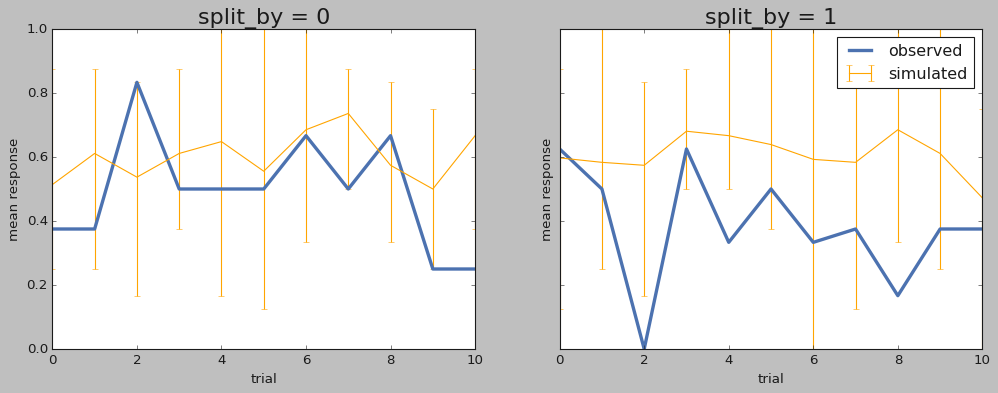

In [230]:
# plotting evolution of choice proportion for best option across learning for observed and simulated data.
fig, axs = plt.subplots(figsize=(15, 5), nrows=1,
                        ncols=2, sharex=True, sharey=True)
for i in range(0, 2):
    ax = axs[i]
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == 'simulated')]
    ax.errorbar(d.bin_trial, d.response, yerr=[
                d.low_err, d.up_err], label='simulated', color='orange')
    d = ppc_sim[(ppc_sim.split_by == i) & (ppc_sim.type == 'observed')]
    ax.plot(d.bin_trial, d.response, linewidth=3, label='observed')
    ax.set_title('split_by = %i' % i, fontsize=20)
    ax.set_ylabel('mean response')
    ax.set_xlabel('trial')
plt.legend()
fig.savefig('PPCchoice.pdf')


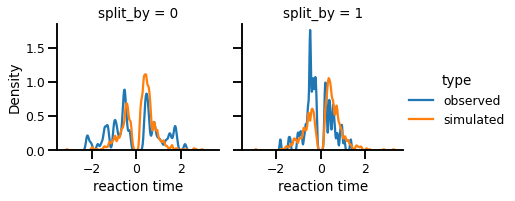

In [208]:
# set reaction time to be negative for lower bound responses (response=0)
plot_ppc_data['reaction time'] = np.where(
    plot_ppc_data['response'] == 1, plot_ppc_data.rt, 0-plot_ppc_data.rt)
# plotting evolution of choice proportion for best option across learning for observed and simulated data. We use bins of trials because plotting individual trials would be very noisy.
g = sns.FacetGrid(plot_ppc_data, col='split_by', hue='type')
g.map(sns.kdeplot, 'reaction time', bw=0.05).set_ylabels("Density")
g.add_legend()
g.savefig('PPCrt_dist.pdf')


## Parameter recovery


In [21]:
param_recovery = hddm.load_csv('recovery_sim_est_rlddm.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'recovery_sim_est_rlddm.csv'